In [1]:
import sys  
import os
path = os.getcwd()
if path.endswith('Notebooks'):
    path = path[:-9]
path = path + str("Source")
sys.path.insert(0, path)
pathData = path + str("\\Data")

import pandas as pd
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split

# header = {"mainGrid", "otherGrids", "hourOfDay"}
# three year power supply records from 1995 to 1998
def dataPreprocesssing():
    df = pd.read_csv(pathData + str('\\powerSupplyStream.csv'))

    # create timestamps
    start = datetime.datetime(1995, 1, 1, 0)
    timestamp_list = [start + datetime.timedelta(hours=x) for x in range(len(df))]
    df['timestamps'] = timestamp_list

    # mistake in hours numbering hour 6 = 1248 instances
    #                                 9 = 1246 instances
    #wrongHoursIndex = [24969]
    #for i in np.arange(len(df)-1):
    #    if df['hourOfDay'][i]+1 != df['hourOfDay'][i + 1] and df['hourOfDay'][i] != 23:
    #        print("wtf")
   # df.at[wrongHoursIndex, 'hourOfDay'] = 9

    df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)
    # hourly change in consumption
    diffMain = np.append(np.array(df_train['mainGrid']), 0) - np.append(0,np.array(df_train['mainGrid']))
    diffMain = diffMain[0:-1]
    diffMain[0] = 0
    diffOthers = np.append(np.array(df_train['otherGrids']), 0) - np.append(0,np.array(df_train['otherGrids']))
    diffOthers = diffOthers[0:-1]
    diffOthers[0] = 0

    df_train['diffMain'] = diffMain
    df_train['diffOthers'] = diffOthers

    df_hourDiffMain = pd.DataFrame()
    df_hourDiffOther = pd.DataFrame()

    return df_train, df_test

train_data, test_data =dataPreprocesssing()
train_data = train_data['mainGrid']
test_data = test_data['mainGrid']
num_train = train_data.size
num_test = test_data.size

In [ ]:
def create_dataset(data, look_back):
  n = data.shape[0]
  x = np.zeros((n - look_back - 1, look_back))
  y = np.zeros(n - look_back - 1)
  for i in range(look_back):
    x[:, i] = data[i:n-look_back+i-1]

  y[:] = data[look_back:n - 1]

  return x, y

In [ ]:
look_back = 3
x_train, y_train = create_dataset(train_data.to_numpy(), look_back)
x_test, y_test = create_dataset(test_data.to_numpy(), look_back)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(23938, 3)
(23938,)
(5982, 3)
(5982,)


In [ ]:
from torch.nn.modules import activation
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.regularizers import l2, l1
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

look_back = 3
x_train, y_train = create_dataset(train_data.to_numpy(), look_back)
x_test, y_test = create_dataset(test_data.to_numpy(), look_back)

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(1, look_back)))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.fit(x_train, y_train, epochs=200, batch_size=64, verbose=1, validation_split=0.2)


Epoch 1/200
300/300 [==============================] - 74s 19ms/step - loss: 11405.2666 - mae: 83.5740 - val_loss: 1699.9689 - val_mae: 36.2890
Epoch 2/200
300/300 [==============================] - 3s 10ms/step - loss: 1202.5416 - mae: 27.6973 - val_loss: 1041.5121 - val_mae: 28.9943
Epoch 3/200
300/300 [==============================] - 3s 10ms/step - loss: 327.6042 - mae: 14.0911 - val_loss: 355.2686 - val_mae: 15.4061
Epoch 4/200
300/300 [==============================] - 3s 10ms/step - loss: 220.3073 - mae: 11.3925 - val_loss: 268.2780 - val_mae: 13.6736
Epoch 5/200
300/300 [==============================] - 3s 10ms/step - loss: 189.7524 - mae: 10.5289 - val_loss: 242.0210 - val_mae: 12.6244
Epoch 6/200
300/300 [==============================] - 3s 10ms/step - loss: 174.5478 - mae: 9.9947 - val_loss: 132.0104 - val_mae: 8.2393
Epoch 7/200
300/300 [==============================] - 3s 10ms/step - loss: 171.8622 - mae: 9.9283 - val_loss: 455.7013 - val_mae: 18.7387
Epoch 8/200
300/3

In [ ]:
score = model.evaluate(x_train, y_train)
score = model.evaluate(x_test, y_test)

187/187 [==============================] - 1s 3ms/step - loss: 123.3172 - mae: 7.9063


187/187 [==============================] - 1s 3ms/step


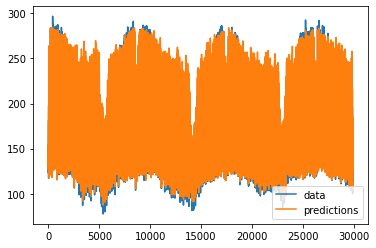

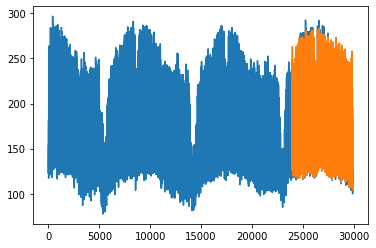

In [ ]:
# make predictions
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

y = np.concatenate((y_train, y_test))
s = y.size
x = range(s)
plt.plot(x, y, label='data')
pred = np.concatenate((pred_train, pred_test))
plt.plot(x, pred, label='predictions')
plt.legend()
plt.show()

y = np.concatenate((y_train, y_test))
s = y.size
x = range(s)
plt.plot(x, y, label='data')
x1 = range(s - pred_test.size, s)
plt.plot(x1, pred_test)
plt.show()